In [1]:
#%matplotlib widget
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import aseg_gdf2
from shapely.geometry import Point, LineString, MultiPoint
from shapely.wkt import loads
from scipy.io import loadmat
from scipy import spatial
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import h5py
import gc
import os
import glob
from scipy.spatial.ckdtree import cKDTree
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils

In [3]:
def nearest_neighbours(points, coords, points_required = 1, max_distance = 250.):
    """

    :param points: array of points to find the nearest neighbour for
    :param coords: coordinates of points
    :param points_required: number of points to return
    :param max_distance: maximum search radius
    :return:
    """
    # Initialise tree instance
    kdtree = cKDTree(data=coords)

    # iterate throught the points and find the nearest neighbour
    distances, indices = kdtree.query(points, k=points_required,
                                      distance_upper_bound=max_distance)
    print(distances)
    # Mask out infitnite distances in indices to avoid confusion
    mask = ~np.isfinite(distances)

    distances[mask] = np.nan

    return distances, indices

# Find the nearest neighbours within the maximum distance

def xy_2_var(grid_dict, xy, var):
    """
    Function for finding a variable for gridded AEM sections
    given an input easting and northing
    @ param: grid_dict :dictionary for gridded line data
    @ param: xy: numpy array with easting and northing
    @ param: var: string with variable name
    returns
    float: distance along line
    """
    utm_coords = np.column_stack((grid_dict['easting'],
                                  grid_dict['northing']))

    d, i = spatial_functions.nearest_neighbours(xy,
                                                utm_coords,
                                                points_required=1,
                                                max_distance=500.)

    near_ind = i[0]

    return grid_dict[var][near_ind]


In [4]:
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\DalyR_WB_MGA52.nc"

lci_dat = netCDF4.Dataset(infile)

lci_coords = np.column_stack((lci_dat['easting'][:],
                          lci_dat['northing'][:]))

# Initialise tree instance for nearest neighbour searches
kdtree = cKDTree(data=lci_coords)


# bring in the rjmcmc data

infile = r"C:\Users\PCUser\Desktop\AEM\rjmcmc\DalyRiver_rjmcmc.nc"

# Read in the data

rj_dat = netCDF4.Dataset(infile)



In [5]:
rj_dat

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 706217.1875
    geospatial_east_max: 867178.5
    geospatial_east_units: m
    geospatial_north_min: 8348056.0
    geospatial_north_max: 8471025.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file rjmcmc.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 21.58
    geospatial_vertical_max: 304.99
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garjmcmctdem_2\combined\rjmcmc.dat using definitions file C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garjmcmctdem_2\combined\rjmcmc.dfn
    date_created: 2020-02-18T14:14:23.238896
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((132.0015 -14.9226, 130.9300 -14.517

In [6]:
# Since we will be wanting to plot the sections lets first grid them

# Create an instance of plots for gridding the data

plots = plot_utils.ConductivitySectionPlot(lci_dat)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 2.


In [8]:
# We will use the lines from the rj

lines = rj_dat['line'][:]

# Now grid the lines and save in memory

hdf5_dir = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\lci\hdf5"

if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

gridded_vars ={}

# Saved these out to save time

#gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
#                                    resampling_method = 'cubic', save_hdf5 = True,
 #                                   return_dict = True, hdf5_dir = hdf5_dir)

for line in lines:
    
    infile = os.path.join(hdf5_dir, str(line) + '.hdf5')
    f = h5py.File(infile, 'r')
    gridded_vars[line] = plot_utils.extract_hdf5_data(f, cond_vars)
    f = None
    gc.collect()

In [73]:
# Now we bring in the Oolloo Jinduckin contact to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\export\topOolloo_BOM.tif"

contact_dataset = rasterio.open(inRaster)

contact_elev = contact_dataset.read(1)

contact_elev[contact_elev == contact_dataset.get_nodatavals()] = np.nan


In [74]:
# Now we bring in the magnetics to plot

inRaster = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\2017_DalyRiver_SkyTEM\03_LCI\03_Depth_Slices\Grids_doi_Masked\*.ers"

cond = {}

for file in glob.glob(inRaster):
    layer = int(file.split('Con')[1].split('_')[0])
    cond_dataset = rasterio.open(file)
    cond[layer] = cond_dataset.read(1)



In [75]:
# Bring in a subset of the points to sample

infile = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\garjmcmctdem_2\combined\rjmcmc_map.csv"

df_all = pd.read_csv(infile)


In [76]:
# Bring in a subset of the points to sample

#infile = r"C:\Users\PCUser\Desktop\NSC_data\data\vector\DalyRiver\strat_bores\ollo_bores_near_AEM.csv"
infile = r"C:\Users\PCUser\Desktop\NSC_data\data\vector\DalyRiver\strat_bores\Florina_bores.csv"


df = pd.read_csv(infile)


In [77]:
# Get the easting and northing

from pyproj import Proj, transform

inProj = Proj(init='epsg:4283')
outProj = Proj(init='epsg:28352')

eastings = []
northings = []

for i in range(len(df)):
    x1,y1 = df['lon'].iloc[i], df['lat'].iloc[i]
    x2,y2 = transform(inProj,outProj,x1,y1)
    eastings.append(x2)
    northings.append(y2)

df['easting'] = eastings
df['northing'] = northings

In [78]:
rj_dat['line'][rj_dat['line_index'][0]].data

array(102701, dtype=int64)

In [79]:
df['rj_ind'] = -9999

df['lci_ind'] = -999

In [80]:
coords = df[['easting', 'northing']].values

rj_coords = np.column_stack((rj_dat['easting'][:].data,
                             rj_dat['northing'][:].data))

lci_coords =  np.column_stack((lci_dat['easting'][:].data,
                             lci_dat['northing'][:].data))

df['nearest_distance.1'] = -9999

for i in range(coords.shape[0]):
    distances, indices = spatial_functions.nearest_neighbours(coords[i:i+1], rj_coords,
                                            points_required = 1, max_distance = 500.)
    if not np.isnan(distances[0]):
        df.at[i, 'rj_ind'] = indices[0]
    
    distances, indices = spatial_functions.nearest_neighbours(coords[i:i+1], lci_coords,
                                            points_required = 1, max_distance = 500.)
    if not np.isnan(distances[0]):
        df.at[i, 'lci_ind'] = indices[0]
        df.at[i, 'nearest_distance.1'] = distances[0]
        


In [81]:
# Drop any points that are not nearby

df = df[df['rj_ind'] != -9999]

In [82]:
# Add the distance along the gridded lines to the dataframe

for index, row in df.iterrows():

    # get the line and coordinates
    line = int(rj_dat['line'][rj_dat['line_index'][row['rj_ind']]])
    
    xy = np.array([row[['easting','northing']].values])
    try:    
        df.loc[index,'dist_along_line'] = xy_2_var(gridded_vars[line],
                                               xy,'grid_distances')
    except IndexError:
        pass

In [83]:
# Create a generator to iterate through the pandas dataframe

def gen(df):
    for index, row in df.iterrows():
        yield index, row
        
#cond_gen = gen(df_rj_ss)


In [53]:
df.to_csv(r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\DR_FlorOlloo_bores_AEM.csv",
         index = False)

In [85]:
def extract_data():
    """
    FUnction for extracting all the AEM data from the netCDF files
    """

    freq = rj_dat['conductivity_bin_count'][point_ind_rj].data.astype(np.float)

    cond_pdf = freq / freq.sum(axis =1)[0]

    cond_pdf[cond_pdf == 0] = np.nan
    
    cp_freq = rj_dat['change_point'][point_ind_rj].data.astype(np.float)
    
    cp_pdf = cp_freq / freq.sum(axis =1)[0]
    
    laybins = rj_dat['nlayer_bin_count'][point_ind_rj].data
    
    lay_prob = laybins / freq.sum(axis =1)[0]
    
    cond_cells = rj_dat["conductivity_cells"][:].data
    
    depth_cells = rj_dat['layer_top_depth'][point_ind_rj].data
    
    extent = [cond_cells.min(), cond_cells.max(), depth_cells.max(), depth_cells.min()]
    
    mean = rj_dat['conductivity_mean'][point_ind_rj].data
    p10 = rj_dat['conductivity_p10'][point_ind_rj].data
    p50 = rj_dat['conductivity_p50'][point_ind_rj].data
    p90 = rj_dat['conductivity_p90'][point_ind_rj].data
    
    lci_cond = lci_dat['conductivity'][point_ind_lci].data
    lci_depth_top = lci_dat['layer_top_depth'][point_ind_lci].data
    
    lci_doi = lci_dat['depth_of_investigation'][point_ind_lci].data
    
    misfit = rj_dat['misfit'][point_ind_rj].data
    sample_no = rj_dat['rj_sample_number'][:].data
    
    burnin = rj_dat["nburnin"][point_ind_rj].data
    nsamples = rj_dat['nsamples'][point_ind_rj].data
    nchains = rj_dat['nchains'][point_ind_rj].data
    
    line_ind = rj_dat['line_index'][point_ind_rj].data
    line = int(rj_dat['line'][line_ind].data)
    
    return {'conductivity_pdf': cond_pdf, "change_point_pdf": cp_pdf, "conductivity_extent": extent,
           'cond_p10': p10, 'cond_p50': p50, 'cond_p90': p90, 'cond_mean': mean, 'depth_cells': depth_cells,
           'nlayer_bins': laybins, 'nlayer_prob': lay_prob, 'nsamples': nsamples, 'ndata': rj_dat['n_data'][:].data,
           "nchains": nchains, 'burnin': burnin, 'misfit': misfit, 'sample_no': sample_no, 'cond_cells': cond_cells, 'lci_cond': lci_cond,
           'lci_depth_top': lci_depth_top, 'lci_doi': lci_doi, 'line': line}
    
def DR_plot(D, outfile = None):
    fig = plt.figure(figsize = (12,10))

    # These are for interactive widget mode
    #fig.canvas.layout.width = '6in'
    #fig.canvas.layout.height= '5in'

    ax1 = fig.add_axes([0.05, 0.35, 0.35, 0.62])
    ax2 = fig.add_axes([0.45, 0.35, 0.2, 0.62])
    ax3 = fig.add_axes([0.70, 0.52, 0.2, 0.2])
    ax4 = fig.add_axes([0.72, 0.32, 0.16, 0.16])
    ax5 = fig.add_axes([0.1, 0.18, 0.76, 0.05])
    ax6 = fig.add_axes([0.1, 0.05, 0.76, 0.13])
    ax7 = fig.add_axes([0.70, 0.78, 0.2, 0.2])
    cbar_ax1 = fig.add_axes([0.05, 0.29, 0.35, 0.01])
    cbar_ax2 = fig.add_axes([0.88, 0.05, 0.01, 0.2])
    
    panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': row['Florina'] + 50.,
                      'shade_doi': True,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 2.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)',
                      'vertical_exaggeration': 1.0}]


    # Plot probability map
    
    im = ax1.imshow(D['conductivity_pdf'], extent = D['conductivity_extent'],
                    aspect = 'auto', cmap = 'rainbow')
    #  PLot the median, and percentile plots
    ax1.plot(np.log10(D['cond_p10']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p10')
    ax1.plot(np.log10(D['cond_p90']), D['depth_cells'], c = 'k',linestyle='dashed', label = 'p90')
    ax1.plot(np.log10(D['cond_p50']), D['depth_cells'], c = 'k',label = 'p50')
    ax1.plot(np.log10(D['cond_mean']), D['depth_cells'], c = 'grey',label = 'mean')
    
    ax1.set_xticklabels([round(10 ** float(x), 4) for x in ax1.get_xticks()])

    # for lci layered model we do some processing
    lci_expanded = np.zeros(shape=2 * len(D['lci_cond']) + 1,
                                 dtype=np.float)

    lci_expanded[1:] = np.repeat(D['lci_cond'], 2)

    depth_expanded = (np.max(D['lci_depth_top']) + 10) * np.ones(shape=len(lci_expanded),
                                                            dtype=np.float)

    depth_expanded[:-1] = np.repeat(D['lci_depth_top'], 2)

    ax1.plot(np.log10(lci_expanded), depth_expanded, c = 'pink',
             linestyle = 'dashed', label = 'lci')
    ax1.plot(ax1.get_xlim(), [D['lci_doi'], D['lci_doi']], c = 'yellow',
             label = 'LCI doi')
    ax1.set_title('rj-MCMC probability map')
    ax1.set_ylabel('depth (mBGL)')
    ax1.set_xlabel('Conductivity (S/m)')
    ax1.grid(which = 'both')
    ax1.set_xlim(D['conductivity_extent'][0], D['conductivity_extent'][1] )
    
    ax1.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#100.,0)#
    ax1.legend(loc = 3)

    ax2.plot(D['change_point_pdf'], D['depth_cells'], label = 'P(change point)')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.set_yticks(np.arange(0, 500, 20.))
    ax2.set_title('change point probability')
    ax2.set_ylim(D['conductivity_extent'][2], D['conductivity_extent'][3])#(100.,0)
    ax2.legend()
    ax2.grid(which = 'both')
    
    #if not np.isclose(row['Jinduckin'], 0.):
    #    ax1.plot(ax1.get_xlim(), [row['Jinduckin'], row['Jinduckin']],
    #            c = 'red')
    #    ax2.plot(ax2.get_xlim(), [row['Jinduckin'], row['Jinduckin']],
    #            c = 'red')
    
    if not np.isclose(row['Oolloo'], 0.):
        ax1.plot(ax1.get_xlim(), [row['Oolloo'], row['Oolloo']],
                c = 'red')
        ax2.plot(ax2.get_xlim(), [row['Oolloo'], row['Oolloo']],
                c = 'red')

    ax3.imshow(contact_elev, 
               extent = [contact_dataset.bounds[0], contact_dataset.bounds[2],
                         contact_dataset.bounds[1], contact_dataset.bounds[3]],
              cmap= 'viridis')#, vmin = -2., vmax = 2.)
    #ax3.set_xlim(D['easting'] - 10000., D['easting'] + 10000.)
    #ax3.set_ylim(D['northing'] - 10000., D['northing'] + 10000.)
    ax3.plot(D['easting'],D['northing'], 'x', c = 'r')
    #ax3.set_title('Oolloo-Jinduckin contact', fontsize=10)
    ax3.set_title("Top Oolloo")
    ax3.tick_params(axis='both', which='major', labelsize=8)
    ax3.tick_params(axis='both', which='minor', labelsize=8)
    # Ax3 will be our location
    sample = D['sample_no'][:]
    
    # Add the misfit
    for i in range(D['misfit'].shape[0]):
       
        misfits = D['misfit'][i]
        ax4.plot(sample, misfits/D['ndata'])

    ax4.plot([1, D['nsamples']], [1,1], 'k')
    ax4.plot([D['burnin'], D['burnin']],[0.1,1e4], 'k')
    ax4.set_xlim([1, D['nsamples']])
    ax4.set_ylim(0.1, 1e4)

    ax4.set_xscale('log')
    ax4.set_yscale('log')

    ax4.set_xlabel("sample #")
    ax4.set_ylabel("Normalised misfit")
    
    # conductivity plot
    
    ax7.imshow(np.log10(cond[9]), extent = [cond_dataset.bounds[0],
                                  cond_dataset.bounds[2],
                                  cond_dataset.bounds[1], 
                                  cond_dataset.bounds[3]],
              cmap = 'jet',
              vmin = np.log10(panel_kwargs[1]['vmin']*1000.),
              vmax = np.log10(panel_kwargs[1]['vmax']*1000.))
    
    ax7.set_xlim(D['easting'] - 10000., D['easting'] + 10000.)
    ax7.set_ylim(D['northing'] - 10000., D['northing'] + 10000.)
    ax7.plot(D['easting'],D['northing'],  'x', c = 'k')
    
    p1 = [gridded_vars[line]['easting'][0], gridded_vars[line]['easting'][-1]]
    p2 = [gridded_vars[line]['northing'][0], gridded_vars[line]['northing'][-1]]
    ax7.plot(p1, p2, 'k', linewidth = 0.5)
    ax7.set_title('LCI depth slice 61.8-71.6 mBGL', fontsize=10)
    ax7.tick_params(axis='both', which='major', labelsize=8)
    ax7.tick_params(axis='both', which='minor', labelsize=8)
    cb1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
    cb1.set_label('probabilitiy', fontsize=10)

    res1 = plot_utils.plot_single_line(ax5, gridded_vars[line],
                                       'data_residual', panel_kwargs[0])

    ax5.set_title('LCI conductivity section - ' + str(line))

    im2 = plot_utils.plot_grid(ax6, gridded_vars[line], 'conductivity',
                               panel_kwargs[1])
    
    # Add colorbars

    ax6.plot([dist, dist], [-500, 500], 'pink')
    
    #if not np.isclose(row['bOoloElev'], 0.):
    #    ax6.plot(dist, row['bOoloElev'], 'x', c = 'red',
    #            markersize = 20)
    if not np.isclose(row['bFloriElev'], 0.):
        ax6.plot(dist, row['bFloriElev'], 'x', c = 'red',
                markersize = 20)
        
    cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation='vertical')
    
    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)
    
    ax5.set_xlim(dist - 5000., dist + 5000.)
    ax6.set_xlim(dist - 5000., dist + 5000.)

    
    
    return fig   

In [86]:
df

,FID,UFI,BORE_NO,BORE_NAME,BOREREPORT,YIELD,COMPL_DATE,COMPLDEPTH,WATERLEVEL,TOTALDEPTH,...,AHDSource,CoxFm,lon,lat,easting,northing,rj_ind,lci_ind,nearest_distance.1,dist_along_line
0,0,7186,RN007509,CLARAVALE STN. DB 17,http://www.ntlis.nt.gov.au/hpa-services/borere...,12.0,9/11/2001 0:00,132.0,58.2,250.0,...,,0,131.606408,-14.325558,781153.002974,8.414685e+06,1113,60107,454,73630.0
1,1,7271,RN007595,Dorisvale Station - WR 18/71,http://www.ntlis.nt.gov.au/hpa-services/borere...,40.0,18/02/1971 0:00,73.1,57.7,73.1,...,,0,131.606047,-14.325526,781114.002743,8.414689e+06,1113,60109,455,73590.0
6,6,31228,RN033615,D.I.P.E. NATURAL RESOURCES,http://www.ntlis.nt.gov.au/hpa-services/borere...,25.0,19/10/2002 0:00,0.0,9.6,180.2,...,,0,131.482199,-14.290093,767788.998837,8.418758e+06,1161,55764,52,59600.0
7,7,32460,RN034900,Claravale Station,http://www.ntlis.nt.gov.au/hpa-services/borere...,0.0,17/10/2005 0:00,24.5,0.0,95.0,...,,0,131.573667,-14.365338,777570.003509,8.410321e+06,1564,120739,157,11530.0
15,15,34545,RN037041,Florina Station,http://www.ntlis.nt.gov.au/hpa-services/borere...,2.5,27/05/2010 0:00,65.9,17.2,162.9,...,,0,131.682716,-14.508736,789152.997646,8.394312e+06,1182,124338,384,3230.0
17,17,34547,RN037043,Florina Station,http://www.ntlis.nt.gov.au/hpa-services/borere...,20.0,17/06/2010 0:00,230.0,16.6,230.0,...,,0,131.682917,-14.508463,789174.998926,8.394342e+06,1182,124340,413,3250.0
18,18,35177,RN037771,TFS Plantations Ltd (Taylor's Park Katherine),http://www.ntlis.nt.gov.au/hpa-services/borere...,1.0,16/11/2012 0:00,144.0,38.0,159.8,...,,0,131.937987,-14.640395,816498.994694,8.379395e+06,1184,91235,124,3540.0
19,19,35176,RN037770,TFS Plantations Ltd (Taylor's Park Katherine),http://www.ntlis.nt.gov.au/hpa-services/borere...,0.0,10/11/2012 0:00,80.0,0.0,0.0,...,,0,131.936717,-14.641838,816360.004932,8.379237e+06,1184,91241,140,3320.0


In [87]:
pts = np.unique(df['rj_ind'].values)

pts

array([1113, 1161, 1182, 1184, 1564], dtype=int64)

C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log10
C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in log10


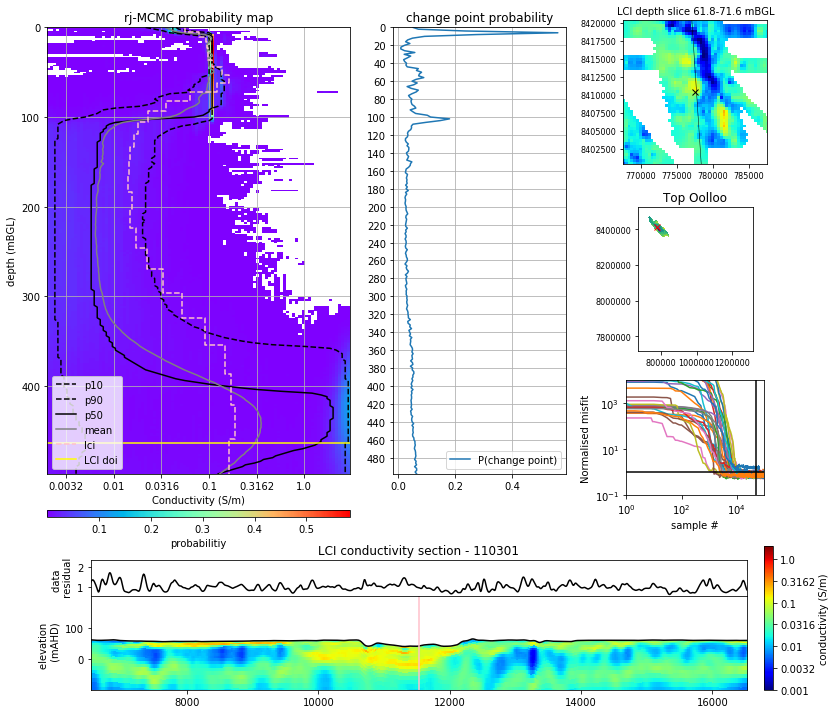

In [93]:
# Define some coordinates to investigate
point_ind_rj = pts[4]

cond_gen = gen(df[df['rj_ind'] == point_ind_rj])


ind, row = next(cond_gen)

# Get the nearest lci point

easting, northing = row['easting'], row['northing']

point_ind_lci= row['lci_ind']

plt.close('all')

D = extract_data()

D['easting'], D['northing'] = easting, northing

line = D['line']

# Find distance along the lci section
dist = xy_2_var(gridded_vars[line],
                 np.array([[easting, northing]]),
                         'grid_distances')

        
fig = DR_plot(D)
plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\rjplots\\Florina_" + row['BORE_NO'] + ".png", dpi = 150)
#cid=  fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()
